# **Vehicle and Object Detection Using YOLO**

About The Dataset: The dataset used in this project consists of videos and images containing various vehicles and objects such as cars, buses, motorcycles, and trucks. The data was manually annotated using the YOLO technique to facilitate training the model for real-time object detection and classification. The dataset includes a variety of scenarios, such as urban streets and highways, to ensure the model generalizes well across different environments.

In [ ]:
%%capture
!pip install roboflow
!pip install pyyaml
!pip install ultralytics

In [ ]:
%pip install opendatasets --upgrade

## Import Necessary Libraries

In [ ]:
# import necessary libraries
from roboflow import Roboflow
import yaml
import os

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO, solutions

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/alkanerturan/vehicledetection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hayaalmalki
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alkanerturan/vehicledetection


100%|██████████| 62.8M/62.8M [00:02<00:00, 29.1MB/s]


In [ ]:
yaml_path = '/content/vehicledetection/VehiclesDetectionDataset/dataset.yaml'
train = '/content/vehicledetection/VehiclesDetectionDataset/train'
valid = '/content/vehicledetection/VehiclesDetectionDataset/valid'
test = '/content/vehicledetection/VehiclesDetectionDataset/test'

In [ ]:
# open yaml filde
with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)

# Update the paths in yaml path
data['train'] = '/content/vehicledetection/VehiclesDetectionDataset/train/images'
data['val'] = '/content/vehicledetection/VehiclesDetectionDataset/valid/images'
data['test'] = '/content/vehicledetection/VehiclesDetectionDataset/test/images'

# Save the updated file
with open(yaml_path, 'w') as file:
    yaml.safe_dump(data, file)

In [ ]:
#Here is about count images in each folder ( train- valid -test)
def count_images(path):
    return len(os.listdir(os.path.join(path, 'images')))

train_count = count_images(train)
val_count = count_images(valid)
test_count = count_images(test)
#print
print(f"Training images: {train_count} \nValidation images: {val_count}\nTest images: {test_count}")

Training images: 878 
Validation images: 250
Test images: 126


In [ ]:
# source: https://python.land/data-processing/python-yaml
with open(yaml_path, 'r') as file:
  data_yaml = yaml.safe_load(file)
class_names = data_yaml['names']
print(class_names)

['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']


## The Visualization and Sample of the Dataset

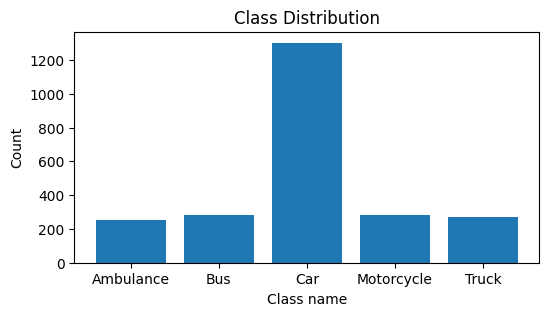

In [ ]:
# Here is about a function to count the class distribution in a given dataset path
def count_class(path):
    labels_path = os.path.join(path, 'labels')
    class_counts = {}

    for label_file in os.listdir(labels_path):
        with open(os.path.join(labels_path, label_file), 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

    return class_counts

# Here is about a function to plot class distribution
def plot_class_distribution(train_path, val_path, test_path, class_names):
    # Here is about count the class images in each dataset
    train_counts = count_class(train_path)
    val_counts = count_class(val_path)
    test_counts = count_class(test_path)

    # Here is about sum the counts in datasets (train, test, val)
    combined_counts = {}
    for class_id in set(train_counts.keys()).union(val_counts.keys()).union(test_counts.keys()):
        combined_counts[class_id] = (
            train_counts.get(class_id, 0) +
            val_counts.get(class_id, 0) +
            test_counts.get(class_id, 0)
        )


    class_df = pd.DataFrame(list(combined_counts.items()), columns=['Class', 'Count'])
    class_df['Class'] = class_df['Class'].apply(lambda x: class_names[x])

    # Plot
    plt.figure(figsize=(6, 3))
    plt.bar(class_df['Class'], class_df['Count'])
    plt.title('Class Distribution')
    plt.xlabel('Class name')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(train, valid, test, class_names)

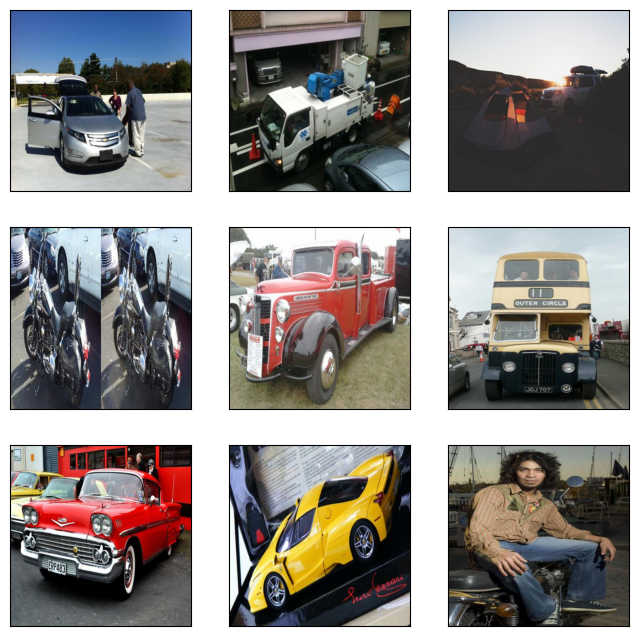

In [ ]:
images_path='/content/vehicledetection/VehiclesDetectionDataset/train/images'
# Here is get the images
image_files = [os.path.join(images_path, f) for f in os.listdir(images_path)[:9]]

# Here is about read the images and convert to RGB
images = []
for img_path in image_files:
    img = cv2.imread(img_path)  # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    images.append(img)


# Here is about display the images in a 3x3
plt.figure(figsize=(8, 8))
for i in range(len(images)):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

## The Preprocessing

In [ ]:
# Here is about preprocessing the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (320, 320))
    image = image / 255.0
    return image

def augment_image(image):
    augmented = cv2.flip(image, 1)
    augmented = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    return augmented

In [ ]:
# Here is about preparing the data  for training
def prepare_dataset(path):
    images_path = os.path.join(path, 'images')
    labels_path = os.path.join(path, 'labels')

    images = []
    labels = []
# Here is about join image with label
    for img_file in os.listdir(images_path):
        img_path = os.path.join(images_path, img_file)
        lbl_path = os.path.join(labels_path, img_file.replace('.jpg', '.txt'))

        image = preprocess_image(img_path) # call preprocess function
        augmented_image = augment_image(image) # call augment function

        with open(lbl_path, 'r') as file:
            label_data = file.read().strip()

        images.append((image, label_data))
        images.append((augmented_image, label_data))

    return images

train_data = prepare_dataset(train) #prepare the data for training
val_data = prepare_dataset(valid) #prepare the data for validation

## Load the Model and Training

In [ ]:
model = YOLO("yolov8n.yaml")

In [ ]:
train_results = model.train(data=yaml_path, epochs=100, batch=16, save_dir='/content/vehicledetection', plots=True)

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/vehicledetection/VehiclesDetectionDataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

100%|██████████| 755k/755k [00:00<00:00, 43.0MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 207MB/s]


AMP: checks passed ✅


train: Scanning /content/vehicledetection/VehiclesDetectionDataset/train/labels... 878 images, 0 backgrounds, 0 corrupt: 100%|██████████| 878/878 [00:00<00:00, 1335.96it/s]

train: New cache created: /content/vehicledetection/VehiclesDetectionDataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/vehicledetection/VehiclesDetectionDataset/valid/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 1122.49it/s]

val: New cache created: /content/vehicledetection/VehiclesDetectionDataset/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.32G      3.307      4.417      4.221         46        640: 100%|██████████| 55/55 [00:10<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

                   all        250        454    0.00187       0.48    0.00268   0.000891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.27G      3.191      4.221      3.991         38        640: 100%|██████████| 55/55 [00:07<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


                   all        250        454    0.00282      0.444    0.00856    0.00244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.29G      3.069      4.096      3.667         36        640: 100%|██████████| 55/55 [00:07<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.32it/s]


                   all        250        454    0.00291      0.446    0.00432    0.00132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.26G      2.904       4.04      3.435         40        640: 100%|██████████| 55/55 [00:07<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.31it/s]


                   all        250        454       0.21      0.162    0.00555    0.00138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.3G      2.745      3.887      3.236         54        640: 100%|██████████| 55/55 [00:07<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


                   all        250        454     0.0112      0.381     0.0141    0.00478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.29G      2.558      3.801      3.088         39        640: 100%|██████████| 55/55 [00:07<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]


                   all        250        454    0.00246      0.317    0.00962    0.00266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.27G      2.389      3.688      2.907         48        640: 100%|██████████| 55/55 [00:07<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]


                   all        250        454     0.0688        0.1     0.0523     0.0236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.28G      2.292       3.62      2.792         37        640: 100%|██████████| 55/55 [00:07<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


                   all        250        454      0.238      0.115     0.0356     0.0122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.25G      2.194      3.482      2.701         42        640: 100%|██████████| 55/55 [00:07<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]


                   all        250        454      0.236     0.0598       0.04     0.0182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.29G      2.104      3.414       2.61         49        640: 100%|██████████| 55/55 [00:07<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


                   all        250        454      0.277     0.0963      0.076     0.0345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.29G      2.067      3.343      2.561         40        640: 100%|██████████| 55/55 [00:08<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        250        454     0.0419      0.336     0.0452     0.0203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.28G      1.987      3.218      2.479         37        640: 100%|██████████| 55/55 [00:07<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        250        454      0.153      0.167      0.101     0.0541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.29G      1.947      3.186       2.45         43        640: 100%|██████████| 55/55 [00:07<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all        250        454      0.128      0.136     0.0935      0.046



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.27G      1.902      3.089      2.406         47        640: 100%|██████████| 55/55 [00:07<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


                   all        250        454      0.344      0.146       0.11     0.0526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.29G      1.877      3.059       2.37         51        640: 100%|██████████| 55/55 [00:07<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


                   all        250        454      0.188      0.195      0.131     0.0637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.26G      1.837      2.981      2.312         44        640: 100%|██████████| 55/55 [00:07<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all        250        454      0.217      0.195      0.166     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.27G      1.805      2.932       2.29         45        640: 100%|██████████| 55/55 [00:07<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


                   all        250        454      0.158      0.239      0.129     0.0687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.29G      1.782      2.886      2.246         55        640: 100%|██████████| 55/55 [00:07<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


                   all        250        454      0.202      0.208      0.177     0.0915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.25G       1.75      2.814      2.244         55        640: 100%|██████████| 55/55 [00:07<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        250        454      0.191      0.274      0.176      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.28G       1.74      2.784      2.205         58        640: 100%|██████████| 55/55 [00:08<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


                   all        250        454      0.205      0.269      0.172     0.0904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.25G        1.7      2.732      2.166         49        640: 100%|██████████| 55/55 [00:07<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


                   all        250        454      0.235      0.284      0.186     0.0921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.27G      1.733      2.733      2.188         33        640: 100%|██████████| 55/55 [00:07<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        250        454      0.202      0.339      0.182     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.25G      1.662      2.603      2.123         68        640: 100%|██████████| 55/55 [00:07<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]

                   all        250        454      0.282      0.305      0.237      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.26G      1.654       2.61       2.14         43        640: 100%|██████████| 55/55 [00:07<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all        250        454      0.285      0.316      0.266      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.27G      1.643      2.591      2.126         51        640: 100%|██████████| 55/55 [00:07<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


                   all        250        454      0.259      0.324      0.217      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.27G      1.625      2.576      2.099         52        640: 100%|██████████| 55/55 [00:07<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        250        454      0.212      0.242      0.163     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.27G      1.602      2.514      2.062         45        640: 100%|██████████| 55/55 [00:07<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]

                   all        250        454      0.404      0.329      0.287       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.28G      1.584      2.467      2.047         42        640: 100%|██████████| 55/55 [00:07<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all        250        454       0.31       0.34      0.254      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.27G      1.599      2.478      2.073         50        640: 100%|██████████| 55/55 [00:07<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all        250        454       0.37      0.308       0.28      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.29G      1.536      2.387      2.002         39        640: 100%|██████████| 55/55 [00:07<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


                   all        250        454      0.307      0.344      0.292      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.29G      1.559      2.396      2.017         39        640: 100%|██████████| 55/55 [00:07<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all        250        454      0.344      0.319        0.3      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.28G      1.529       2.37      2.003         68        640: 100%|██████████| 55/55 [00:07<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        250        454      0.365       0.36      0.303      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.27G      1.492      2.325      1.977         51        640: 100%|██████████| 55/55 [00:07<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]

                   all        250        454      0.326      0.402      0.291      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.29G      1.501      2.309      1.977         42        640: 100%|██████████| 55/55 [00:07<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all        250        454      0.364      0.382      0.344      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.27G      1.478      2.251      1.947         60        640: 100%|██████████| 55/55 [00:07<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


                   all        250        454      0.326      0.398      0.312       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.28G      1.504      2.267      1.965         59        640: 100%|██████████| 55/55 [00:07<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all        250        454      0.393      0.325        0.3      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.29G      1.466      2.249      1.939         52        640: 100%|██████████| 55/55 [00:07<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]

                   all        250        454      0.367      0.462      0.338      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.29G      1.441      2.212        1.9         51        640: 100%|██████████| 55/55 [00:07<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        250        454      0.392      0.369      0.328      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.29G      1.444      2.156      1.899         33        640: 100%|██████████| 55/55 [00:07<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]

                   all        250        454      0.286       0.34      0.285      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.28G      1.466      2.173      1.923         59        640: 100%|██████████| 55/55 [00:07<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]

                   all        250        454        0.5      0.319      0.358      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.27G      1.424      2.126      1.889         39        640: 100%|██████████| 55/55 [00:07<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]

                   all        250        454      0.333      0.496      0.379      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.29G      1.435      2.149      1.877         55        640: 100%|██████████| 55/55 [00:07<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all        250        454      0.478       0.33      0.371      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.27G      1.392      2.095      1.853         48        640: 100%|██████████| 55/55 [00:07<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]

                   all        250        454      0.485      0.425      0.416      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.28G      1.404      2.066      1.859         49        640: 100%|██████████| 55/55 [00:07<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]

                   all        250        454      0.516      0.432      0.401      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.29G      1.439      2.088      1.878         45        640: 100%|██████████| 55/55 [00:07<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]

                   all        250        454      0.392       0.37      0.334      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.27G      1.394      2.058      1.862         40        640: 100%|██████████| 55/55 [00:07<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]

                   all        250        454      0.439      0.389      0.402      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.29G      1.374      2.009       1.84         45        640: 100%|██████████| 55/55 [00:07<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all        250        454      0.417      0.377       0.34      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.26G      1.369      2.009      1.835         51        640: 100%|██████████| 55/55 [00:07<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]

                   all        250        454      0.483      0.388      0.413      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.29G      1.353      1.974      1.817         70        640: 100%|██████████| 55/55 [00:07<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]

                   all        250        454      0.532       0.38       0.42      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.29G      1.366      1.955      1.823         50        640: 100%|██████████| 55/55 [00:07<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all        250        454      0.496      0.375      0.401      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.29G      1.339      1.972      1.804         57        640: 100%|██████████| 55/55 [00:07<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]

                   all        250        454      0.535      0.411      0.418      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.29G      1.311      1.906      1.766         46        640: 100%|██████████| 55/55 [00:07<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]

                   all        250        454       0.49       0.49      0.425      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.27G      1.312      1.879      1.775         60        640: 100%|██████████| 55/55 [00:07<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all        250        454      0.465      0.421      0.402      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.29G      1.315      1.858       1.78         57        640: 100%|██████████| 55/55 [00:07<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]

                   all        250        454      0.523      0.431      0.416      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.27G      1.334      1.871      1.795         55        640: 100%|██████████| 55/55 [00:07<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all        250        454      0.396      0.442      0.411       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.29G       1.34      1.882      1.783         43        640: 100%|██████████| 55/55 [00:07<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]

                   all        250        454      0.371      0.422      0.394       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.3G      1.293      1.827      1.729         44        640: 100%|██████████| 55/55 [00:07<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all        250        454      0.461      0.441      0.409      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.29G      1.323      1.832      1.776         44        640: 100%|██████████| 55/55 [00:07<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]

                   all        250        454      0.456      0.393      0.422      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.29G      1.261      1.823      1.736         55        640: 100%|██████████| 55/55 [00:07<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]

                   all        250        454      0.535       0.43      0.437        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.28G      1.293      1.811       1.75         67        640: 100%|██████████| 55/55 [00:07<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        250        454      0.534      0.367      0.397      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.29G      1.294      1.806      1.743         53        640: 100%|██████████| 55/55 [00:07<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]

                   all        250        454      0.485      0.412      0.411      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.28G      1.286      1.784      1.735         55        640: 100%|██████████| 55/55 [00:07<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]

                   all        250        454        0.5      0.452      0.449      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.25G      1.251      1.751      1.711         47        640: 100%|██████████| 55/55 [00:07<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all        250        454      0.513      0.397       0.43      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.29G      1.251      1.735      1.708         65        640: 100%|██████████| 55/55 [00:07<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]

                   all        250        454      0.536      0.415      0.419      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.3G      1.241      1.717      1.694         66        640: 100%|██████████| 55/55 [00:07<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        250        454      0.552      0.417      0.434      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.29G      1.241      1.673      1.699         78        640: 100%|██████████| 55/55 [00:07<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]

                   all        250        454      0.668      0.357      0.425      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.29G      1.266      1.696      1.711         49        640: 100%|██████████| 55/55 [00:07<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]

                   all        250        454      0.515      0.417       0.43      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.28G      1.191      1.635      1.659         54        640: 100%|██████████| 55/55 [00:07<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]

                   all        250        454      0.537      0.428      0.471      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.27G      1.217      1.636      1.665         45        640: 100%|██████████| 55/55 [00:07<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]

                   all        250        454      0.473      0.482      0.451      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.29G      1.215      1.644      1.663         52        640: 100%|██████████| 55/55 [00:07<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all        250        454       0.66      0.398      0.462      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.25G      1.217      1.636      1.668         62        640: 100%|██████████| 55/55 [00:07<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all        250        454      0.557      0.401      0.451      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.26G      1.179      1.577      1.639         49        640: 100%|██████████| 55/55 [00:07<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]

                   all        250        454      0.495       0.48       0.46      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.25G       1.17      1.591       1.64         43        640: 100%|██████████| 55/55 [00:07<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all        250        454      0.544      0.433      0.461      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.27G      1.189      1.593      1.647         36        640: 100%|██████████| 55/55 [00:07<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all        250        454      0.499      0.434      0.448      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.27G      1.186      1.555      1.641         48        640: 100%|██████████| 55/55 [00:07<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        250        454      0.698      0.384      0.492      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.28G      1.181      1.574      1.625         51        640: 100%|██████████| 55/55 [00:08<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]

                   all        250        454      0.523       0.44      0.471      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.29G      1.175      1.578      1.642         35        640: 100%|██████████| 55/55 [00:07<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]

                   all        250        454      0.553      0.413      0.428        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.27G      1.172      1.557      1.616         68        640: 100%|██████████| 55/55 [00:07<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all        250        454      0.601      0.447      0.488       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.27G      1.139      1.541      1.616         43        640: 100%|██████████| 55/55 [00:07<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]

                   all        250        454      0.643      0.428      0.472      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.29G      1.149      1.512      1.606         56        640: 100%|██████████| 55/55 [00:07<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        250        454      0.599      0.426      0.446      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.29G      1.135      1.496      1.596         55        640: 100%|██████████| 55/55 [00:07<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]

                   all        250        454      0.512      0.531      0.487      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.29G      1.159      1.503      1.598         62        640: 100%|██████████| 55/55 [00:07<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]

                   all        250        454      0.478      0.484      0.457       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.27G      1.138      1.475      1.601         44        640: 100%|██████████| 55/55 [00:07<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all        250        454      0.671      0.458      0.488      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.28G      1.107      1.452      1.585         57        640: 100%|██████████| 55/55 [00:07<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]

                   all        250        454      0.525       0.44      0.467      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.29G      1.112      1.467      1.571         41        640: 100%|██████████| 55/55 [00:07<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all        250        454       0.53       0.52      0.486      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.27G      1.127       1.44      1.588         40        640: 100%|██████████| 55/55 [00:07<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]

                   all        250        454      0.662       0.43      0.511      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.29G      1.085      1.405      1.566         56        640: 100%|██████████| 55/55 [00:07<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]

                   all        250        454       0.73      0.416       0.51      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.28G      1.137      1.444      1.602         49        640: 100%|██████████| 55/55 [00:07<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        250        454      0.571      0.473      0.495      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.27G      1.113       1.42      1.566         65        640: 100%|██████████| 55/55 [00:07<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]

                   all        250        454      0.567      0.492      0.481      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.29G      1.099      1.395      1.564         52        640: 100%|██████████| 55/55 [00:07<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        250        454      0.539      0.515      0.516      0.366


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.25G     0.9865      1.206      1.484         26        640: 100%|██████████| 55/55 [00:09<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]

                   all        250        454      0.569      0.471      0.514      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.26G     0.9723      1.131       1.48         20        640: 100%|██████████| 55/55 [00:07<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]

                   all        250        454      0.672      0.427      0.482      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.27G      0.939      1.102      1.463         26        640: 100%|██████████| 55/55 [00:07<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        250        454       0.61      0.498      0.522      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.27G     0.9442      1.076      1.455         26        640: 100%|██████████| 55/55 [00:07<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]

                   all        250        454      0.644       0.43      0.488      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.25G      0.928      1.056      1.443         25        640: 100%|██████████| 55/55 [00:07<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]

                   all        250        454      0.669      0.435      0.506      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.26G     0.9162      1.036      1.424         22        640: 100%|██████████| 55/55 [00:07<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]

                   all        250        454      0.641      0.416      0.487      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.25G     0.9121      1.025      1.429         20        640: 100%|██████████| 55/55 [00:08<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]

                   all        250        454      0.598       0.47      0.498      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.25G     0.9009      1.001      1.409         27        640: 100%|██████████| 55/55 [00:07<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all        250        454      0.675      0.429      0.503      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.25G     0.9044     0.9944      1.418         20        640: 100%|██████████| 55/55 [00:07<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]

                   all        250        454      0.683      0.423      0.497      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.26G     0.8764      0.979      1.395         22        640: 100%|██████████| 55/55 [00:07<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all        250        454      0.659      0.449      0.504      0.368



100 epochs completed in 0.278 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.48it/s]


                   all        250        454      0.627      0.489      0.521      0.369
             Ambulance         50         64      0.717      0.719      0.799      0.663
                   Bus         30         46      0.771      0.609      0.665      0.491
                   Car         90        238      0.581      0.338      0.376      0.237
            Motorcycle         42         46      0.547      0.478      0.454      0.263
                 Truck         38         60      0.519        0.3      0.311      0.192
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


In [ ]:
valid_results = model.val(data=yaml_path, plots=True)

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/vehicledetection/VehiclesDetectionDataset/valid/labels.cache... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]


                   all        250        454      0.608      0.494      0.522      0.368
             Ambulance         50         64      0.714      0.719      0.799      0.659
                   Bus         30         46      0.737       0.61      0.667      0.492
                   Car         90        238      0.574      0.362      0.376      0.237
            Motorcycle         42         46        0.5      0.478      0.454      0.263
                 Truck         38         60      0.516        0.3      0.311      0.192
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to runs/detect/train2


## The Model Evaluation

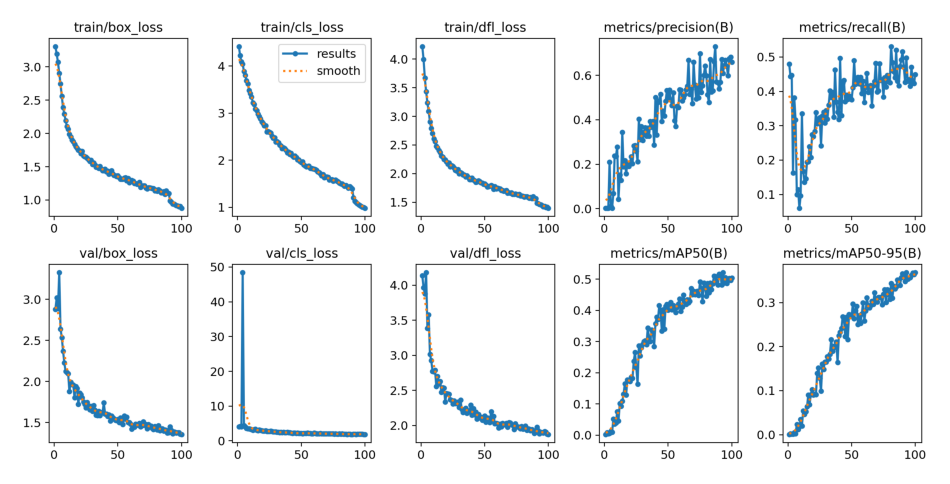

In [ ]:
#Here is about visualize the results:
image_path = '/content/runs/detect/train/results.png'

# Here is about read the image
img = cv2.imread(image_path)

# Here is about convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Here is about display the image
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

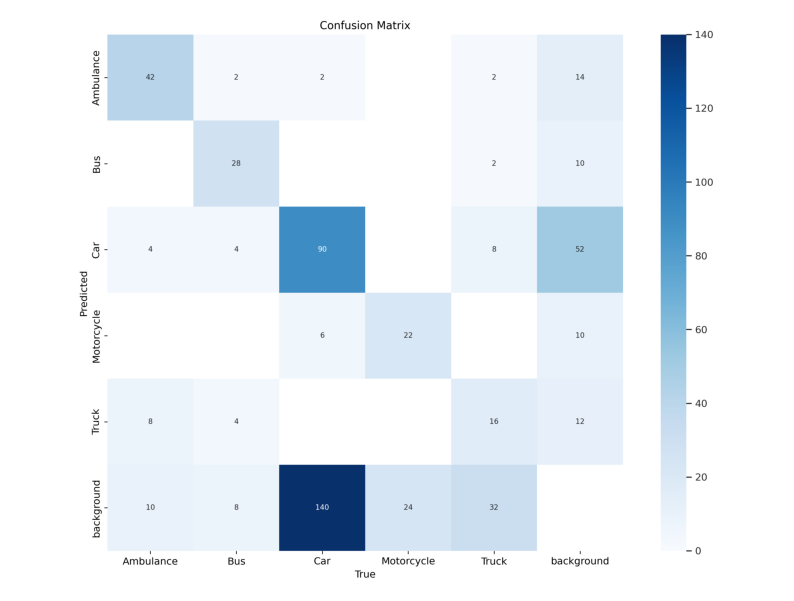

In [ ]:
image_path = '/content/runs/detect/train/confusion_matrix.png'

img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

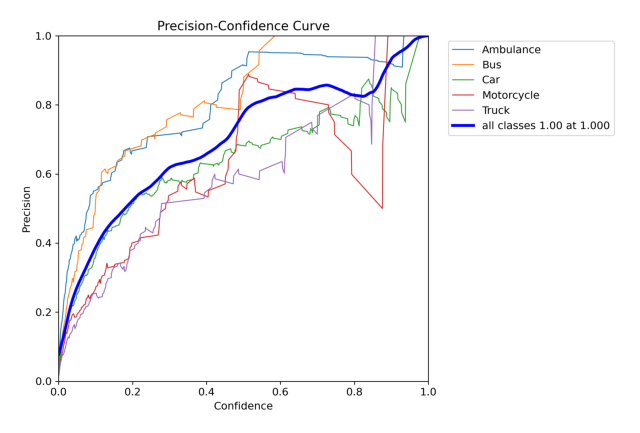

In [ ]:
image_path = '/content/runs/detect/train/P_curve.png'

img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

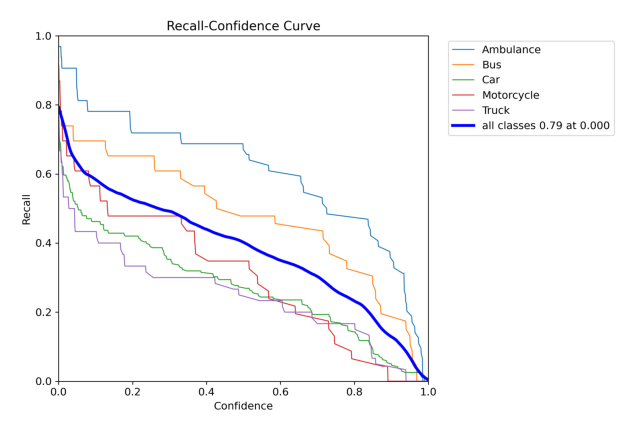

In [ ]:
image_path = '/content/runs/detect/train/R_curve.png'

img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

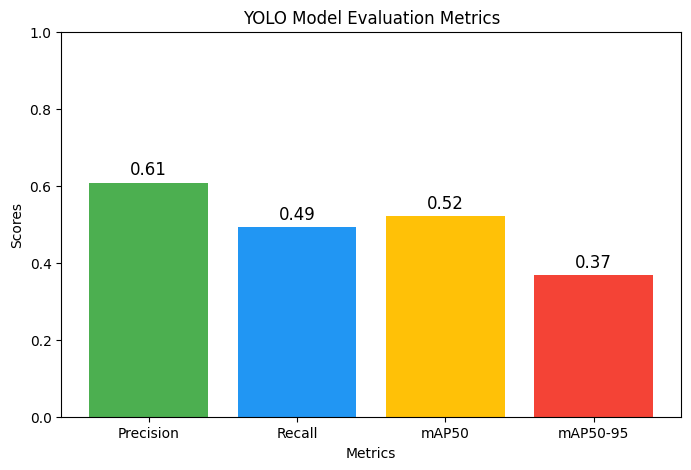

In [ ]:
# Here is about returns a list of the average values ​​of the metrics
mean_results =  valid_results.mean_results()

# Here is about put the values ​​in list form
metrics_names = ['Precision', 'Recall', 'mAP50', 'mAP50-95']
metrics_values = [mean_results[0], mean_results[1], mean_results[2], mean_results[3]]

# Here is about plot the results using matplotlib
plt.figure(figsize=(8, 5))
plt.bar(metrics_names, metrics_values, color=['#4CAF50', '#2196F3', '#FFC107', '#F44336'])
plt.title('YOLO Model Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.ylim(0, 1)
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=12)
plt.show()

In [ ]:
best_model = YOLO('/content/runs/detect/train/weights/best.pt')

In [ ]:
video_path = '/content/vehicledetection/TestVideo/TrafficPolice.mp4'
cap = cv2.VideoCapture(video_path)
print(cap.isOpened())

True


In [ ]:
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [ ]:
output_video = 'output_with_detection.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

In [ ]:
# Here is about read the video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Here is about applying the model to the frame
    results = best_model(frame)

    # Here is about draw bounding box
    annotated_frame = results[0].plot()

    # Here is about write  to output
    out.write(annotated_frame)

Streaming output truncated to the last 5000 lines.
0: 384x640 5 Cars, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 Cars, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 Cars, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Cars, 1 Motorcycle, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Cars, 1 Motorcycle, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 Cars, 1 Motorcycle, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 Cars, 1 Motorcycle, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 Cars, 1 Motorcycle, 7.4ms


In [ ]:
# Here is about release and close videos
cap.release()
out.release()
cv2.destroyAllWindows()